## Project 4 – Work In Progress

* Student name: Greg Osborne
* Student pace: self paced / part time
* Scheduled project review date/time: 2/7/22
* Instructor name: Morgan Jones
* Blog post URL: https://medium.com/@gregosborne

# The work below is not meant as a final project. It is a developing project.

# Stakeholder: Google
# Problem: Some people have a better public perception of Google and it's cheif competitor, Apple. In building a more positive perception for Google.

Google's PR and product development departments could benefit from an NLP model that can provide a snapshot of the public's perception of both Google and their competition, Apple. The [insert what the model does here]

1. [itemized list]

FurPig accepted the challenge and gave the project to Data Scientist Greg Osborne.

# Python Libraries

In [1]:
#DataFrames and computation
import pandas as pd
import numpy as np

#The Train/Test Split
from sklearn.model_selection import train_test_split

#For Categorical Variables
#from sklearn.preprocessing import OneHotEncoder

#For Min/Max Scaling
#from sklearn.preprocessing import MinMaxScaler

#Logistic Regression Model
#from sklearn.linear_model import LogisticRegression

# Scores
#from sklearn.metrics import precision_score, recall_score, accuracy_score
#from sklearn.metrics import f1_score

# For Frequency Distributions
from nltk import FreqDist
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

#Import the Tokenize library
from nltk.tokenize import RegexpTokenizer

# For Wordclouds
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

# The Confusion Matrix
#import matplotlib.pyplot as plt
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix

#Decision Tree Analysis
#from sklearn.tree import DecisionTreeClassifier 
#from sklearn import tree
#from sklearn.metrics import roc_curve, auc

# Import StandardScaler
#from sklearn.preprocessing import StandardScaler

# Import KNeighborsClassifier
#from sklearn.neighbors import KNeighborsClassifier

# Import Bagging Trees
#from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# For XG Boost
#from sklearn.model_selection import GridSearchCV
#from xgboost import XGBClassifier

#Setting DataFrame Display settings
pd.set_option("display.max_rows", 600)

# Custom Functions

### *function_name*: Function description

In [2]:
#Creates a dictionary of specified keys with a count as the values, and then
#sorts the list from greatest to least.
def tally(lst):
    tally_dict = {}
    for item in lst:
        if item not in tally_dict:
            tally_dict[item] = 1
        else:
            tally_dict[item] += 1
    #Sorting the dictionaries
    count = sorted(tally_dict.items(), key=lambda x:x[1],reverse = True)
    return count

In [3]:
#Creating a df of nothing but the retweets
def retweet_trim_one(dfone):
    for i in range(len(dfone)):
        twt = dfone.loc[i,'Tokens']
        #Twitter parlance: rt = retweet
        #Dropping all tweets that don't start in rt
        if 'rt' != twt[0]:
            dfone.drop(index = i,inplace=True)
    return dfone

In [4]:
#Creating a new column that will have the same tokens, just without rt or
#mention at the beginning.

def retweet_trim_two(dftwo, drop_first_words = ['skip'], drop_num = 1):
    #Creating a column to put the trimmed retweet
    dftwo['trimmed_rt'] = 'Blank'
    dftwo['Match'] = False

        
    #I want to test the data to see if there's anything that stands out as
    #repetitive in the first or second words of the newly trimmed tweets.
    #Creating a list of the first and second words of each trimmed tweet.
    firstword_lst = []
    secondword_lst = []
    
    #Starting a list to drop any retweets. 
    retweets_to_drop = []
    
    for i in dftwo.index:
        #making the trimmed variable, the tokens of the next tweet to edit
        trimmed = dftwo.at[i,'Tokens']
        #Removing the set number of dropped tokens. 
        #Default is just the first token, "rt."
        trimmed = trimmed[drop_num:]
        if len(trimmed) == 0:
            if drop_num == 1:
                retweets_to_drop.append(i)
            continue
        #Several retweets include 'mention' after the rt, so I'll trim that.
        #This while loop quits dropping words with the first token that isn't
        #in the drop list specified by parameter.
        if drop_first_words != ['skip']:
            while trimmed[0] in drop_first_words:
                trimmed = trimmed[1:]
                #Some tweets contained only "rt" and "mention," and are now
                #empty."
                #Adding any empty token lists to the retweets_to_drop list.
                if len(trimmed) == 0:
                    if drop_num == 1:
                        retweets_to_drop.append(i)
                    break
        if len(trimmed) == 0:
            continue
        
        #Adding first and second words of the trimmed tweet to the lists.
        firstword_lst.append(trimmed[0])
        secondword_lst.append(trimmed[1])
        
        #Replacing the trimmed tokens to a new column, "trimmed_rt".
        dftwo.at[i,'trimmed_rt'] = trimmed
    
    #I want to test the data to see if there's anything that stands out as
    #repetitive in the first word of the newly trimmed tweets.
    #Creating a dictionary to count the first word in each trimmed tweet.
    
    firstword_count = tally(firstword_lst)
    secondword_count = tally(secondword_lst)
    
    return dftwo, firstword_count, secondword_count, retweets_to_drop

In [5]:
#Checking to see if any of theses newly trimmed retweets are exact matches of
#Original tweets in the dataset.

def retweet_trim_three(dfthree, dforg, retweets_to_drop):
    original_tweets = []
    
    for i in dforg.index:
        original_tweets.append(dforg.at[i,'Tokens'])
    
    for i in dfthree.index:
        retweet = dfthree.at[i,'trimmed_rt']
        if retweet in original_tweets:
            dfthree.at[i,'Match'] = True
            retweets_to_drop.append(i)
    
    return dfthree, retweets_to_drop

In [6]:
#Creating a single function that runs all of the previous functions but allows
#a lister parameter to choose what words are filtered out of the first words.
def retweet_trim_all(retweets, word_list = ['skip'], delete = True, drop = 1):
    retweets = retweet_trim_one(retweets)
    retweets, fw, sw, rtd = retweet_trim_two(retweets, word_list, drop)
    retweets, rtd = retweet_trim_three(retweets, df, rtd)
    #Dropping the tweets.
    if delete == False:
        print(retweets['Match'].value_counts())
        return retweets.loc[retweets['Match'] == True]
    df.drop(index = rtd, inplace=True)
    df.reset_index(drop = True, inplace = True)
    return retweets['Match'].value_counts()

In [7]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

In [8]:
def setup_twelve_subplots():
    fig = plt.figure(figsize=(9,12))
    fig.set_tight_layout(True)
    gs = fig.add_gridspec(4, 3)
    ax1  = fig.add_subplot(gs[0, 0])
    ax2  = fig.add_subplot(gs[0, 1])
    ax3  = fig.add_subplot(gs[0, 2])
    ax4  = fig.add_subplot(gs[1, 0])
    ax5  = fig.add_subplot(gs[1, 1])
    ax6  = fig.add_subplot(gs[1, 2])
    ax7  = fig.add_subplot(gs[2, 0])
    ax8  = fig.add_subplot(gs[2, 1])
    ax9  = fig.add_subplot(gs[2, 2])
    ax10 = fig.add_subplot(gs[3, 0])
    ax11 = fig.add_subplot(gs[3, 1])
    ax12 = fig.add_subplot(gs[3, 2])
    return fig, [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]

In [9]:
def plots(column, axes, title="Word Frequency for"):
    ax_num = 0
    for index, category in zip(df_target.index, df_target.values):
        # Calculate frequency distribution for this subset
        all_words = df[df["Target"] == index][column].explode()
        freq_dist = FreqDist(all_words)
        top_10 = list(zip(*freq_dist.most_common(10)))
        tokens = top_10[0]
        counts = top_10[1]

        # Set up plot
        ax = axes[ax_num]
        ax.bar(tokens, counts)

        # Customize plot appearance
        ax.set_title(f"{title} \n {str(category)[2:-2]}")
        ax.set_ylabel("Count")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis="x", rotation=90)
        ax_num += 1

In [10]:
def wc(tokens, title = '', morestopwords = []):
    text = " ".join(i for i in tokens.explode())
    stopwords = set(STOPWORDS)
    stopwords.update(morestopwords)
    wordcloud = WordCloud(
            stopwords=stopwords, background_color="white").generate(text)
    fig = plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    fig.set_tight_layout(True)


    if title != '':
        fig.suptitle(title, fontsize=48);
    plt.show()

In [11]:
def word_cloud_grid(morestopwords = [], title = ''):
    tgt_lst = []
    wc_lst = []
    tgt_num = list(df_target.index)
    
    #df.loc[df['Target'] > 400]
    
    for num in tgt_num:
        tgt_lst.append(" ".join(
            i for i in df['Tokens'].loc[df['Target'] == num].explode()))
    stopwords = set(STOPWORDS)
    stopwords.update(morestopwords)
    for tgt in tgt_lst:
        wc_lst.append(WordCloud(
            stopwords=stopwords, background_color="white").generate(tgt))
    fig = plt.figure(figsize=(9,9))
    fig.set_tight_layout(True)
    gs = fig.add_gridspec(4, 3)
    ax1  = fig.add_subplot(gs[0, 0])
    ax2  = fig.add_subplot(gs[0, 1])
    ax3  = fig.add_subplot(gs[0, 2])
    ax4  = fig.add_subplot(gs[1, 0])
    ax5  = fig.add_subplot(gs[1, 1])
    ax6  = fig.add_subplot(gs[1, 2])
    ax7  = fig.add_subplot(gs[2, 0])
    ax8  = fig.add_subplot(gs[2, 1])
    ax9  = fig.add_subplot(gs[2, 2])
    ax10 = fig.add_subplot(gs[3, 0])
    ax11 = fig.add_subplot(gs[3, 1])
    ax12 = fig.add_subplot(gs[3, 2])
    
    i = 0
    for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]:
        ax.axis("off")
        ax.imshow(wc_lst[i], interpolation='bilinear')
        ref = tgt_num[i]
        ax.set_title(f"Word Cloud \n {df_target.at[ref,'Target Text']}")
        i+=1
    if title != '':
        fig.suptitle(title, fontsize=36);
    plt.show()

# Loading the data and previewing it.

In [12]:
df_raw = pd.read_csv("judge-1377884607_tweet_product_company.csv", 
                     encoding='ANSI')
df_raw.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [13]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


### Value counts of categorized columns

In [14]:
df_raw['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [15]:
df_raw['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

Analysis and explanation of next steps.

# Data Cleaning

### Rename Columns

In [16]:
name = {'tweet_text' : 'Tweet',
        'emotion_in_tweet_is_directed_at':'Product',
        'is_there_an_emotion_directed_at_a_brand_or_product': 'Emotion'}
df = df_raw.rename(columns=name)
df.head()

,Tweet,Product,Emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Standardizing Case

In [17]:
df['Tweet'] = df['Tweet'].str.lower()
df.head()

,Tweet,Product,Emotion
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion


### Testing for bad data

In [18]:
#Testing for any Tweets that are not strings
bad_tweets = []
for i in range(len(df)):
    typ = type(df.at[i,'Tweet'])
    if typ != str:
        print('Index number {} is a {}, not a string'.format(i,typ))
        bad_tweets.append(i)

Index number 6 is a <class 'float'>, not a string


In [19]:
#Dropping bad data and reseting the index
df.drop(index = bad_tweets, inplace=True)
df.reset_index(drop = True, inplace = True)
df.head(8)

,Tweet,Product,Emotion
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion
5,@teachntech00 new ipad apps for #speechtherapy...,NaN,No emotion toward brand or product
6,"#sxsw is just starting, #ctia is around the co...",Android,Positive emotion
7,beautifully smart and simple idea rt @madebyma...,iPad or iPhone App,Positive emotion


### Tokenize
The process of tokenizing the data is to turn each tweet into a list, with each element being a single item in the list.

In [20]:
#Creating the tokenizer
basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)

In [21]:
#Creating a new column for the tokenized tweet
df['Tokens'] = None

#Creating the token lists
for i in range(len(df)):
    df['Tokens'][i] = tokenizer.tokenize(df['Tweet'][i])
df.head(5)

,Tweet,Product,Emotion,Tokens
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,"[wesley83, have, 3g, iphone, after, hrs, tweet..."
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, about, fludapp, awesome, ipad..."
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,"[swonderlin, can, not, wait, for, ipad, also, ..."
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[sxsw, hope, this, year, festival, isn, as, cr..."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, on, fri, sxsw, maris..."


### Checking for duplicate tweets in the form of retweets.
There's no need to have the same words analyzed twice, except one begins with "rt" and a mention. So, I'll get rid of all retweets that have the original tweet in the dataset.

The process of checking for retweets can be done multiple times with slighly different parameters. Sometimes, it's necessary to check for certain words at the beginning. Other times, just trimming the beginning off by a certain number of words is all that's needed. Therefore, I created four functions the make this process simpler. The functions are at the top of this worksheet.

The four steps are:
1. Create Dataframe with nothing but the retweets, including the tokenized version.
2. Trim the retweet by soecified parameters.
3. Check to see if there are any exact matches of the trimmed retweets in the original dataset.
4. Purge the retweets.

The final step is wrapped into another function that performs all of these steps at once.

In [22]:
#Creating a copy of the dataframe.
retweets = df.copy()

#Purging original tweets from the new copy, so that all that is left
#are retweets.
retweets = retweet_trim_one(retweets)

#Creating an initial count of all retweets
retweet_count = len(retweets)

#Previewing the retweets.
retweets.head()

,Tweet,Product,Emotion,Tokens
24,rt @laurieshook: i'm looking forward to the #s...,iPad,Positive emotion,"[rt, laurieshook, looking, forward, to, the, s..."
25,"rt haha, awesomely rad ipad app by @madebymany...",iPad or iPhone App,Positive emotion,"[rt, haha, awesomely, rad, ipad, app, by, made..."
199,rt ' it's 4 p.m. and the #ipad2 line at the ap...,NaN,No emotion toward brand or product,"[rt, it, and, the, ipad2, line, at, the, apple..."
867,"rt hiring marketers, designers, creatives, soc...",NaN,No emotion toward brand or product,"[rt, hiring, marketers, designers, creatives, ..."
1054,l.a.m.e. rt @mention &quot;...by the law of a...,Other Google product or service,Negative emotion,"[rt, mention, quot, by, the, law, of, averages..."


In [23]:
#Trimming the retweets of the first "rt" and the subsequent word "mention."
retweets, fw, sw, rtd = retweet_trim_two(retweets, ['mention'])

In [24]:
#Checking to see if any of the trimmed retweets match any original tweets in
#the dataset.
retweets, rtd = retweet_trim_three(retweets, df, rtd)

#If a the Match column value is True, then the retweet matches an original 
#tweet and will be deleted in the next cell
retweets['Match'].value_counts()

True     1461
False     529
Name: Match, dtype: int64

In [25]:
#Dropping the duplicate retweets from the original dataset.
df.drop(index = rtd, inplace=True)

#Resetting the dataset's index.
df.reset_index(drop = True, inplace = True)

### Trying other methods to identify and delete duplicate tweets.
For reasons I don't understand, some of the tweets were retweets of retweets. So I'll check if there were even more retweets of originals in the dataset.

First, I decided to expand the key word search at the beginning of each retweet. To do this, I decided to preview what words came up first and second in the previously trimmed retweets.

In [26]:
#A list of the top ten first words after the previous trimming.
fw[0:10]

[('rt', 162),
 ('google', 159),
 ('apple', 92),
 ('sxsw', 78),
 ('the', 48),
 ('we', 42),
 ('quot', 41),
 ('at', 36),
 ('just', 30),
 ('new', 29)]

In [27]:
#A list of the top ten second words after the previous trimming.
sw[0:10]

[('mention', 226),
 ('to', 127),
 ('sxsw', 77),
 ('is', 58),
 ('google', 49),
 ('the', 44),
 ('you', 40),
 ('ipad', 30),
 ('apple', 27),
 ('of', 26)]

From the list above, I tried multiple combinations of the more popular, significant, words to see if trimming those words found more matches to the orginal tweets in the dataset. After several combinations of the words "mention, sxsw, google, apple, rt, and quot," the two combinations below were the only two that found any matches at all. Together, they found four matches and deleted all four.

In [28]:
#Before each run through these functions, I need to make a new copy of the 
#retweets DafaFrame.
retweets = df.copy()

#Checking for multiple subsequent copies of both "rt" and "mention."
retweet_trim_all(retweets, ['rt','mention'])

False    527
True       1
Name: Match, dtype: int64

In [29]:
#Checking for multiple subsequent copies of just "rt."
retweets = df.copy()
retweet_trim_all(retweets, ['rt'])

False    524
True       3
Name: Match, dtype: int64

A strange thing about this dataset, is it seems clear that the word "mention" is used in lieu of the user's name. The metadata to the dataset contained no explanation as to why this is happening, but I suspect it's to protect the user's privacy. However, the whole set is not like this. Several tweets do contain the @ symbol followed by a twitter username. So several tweets begin "rt @username" with the username being specific to the person being retweeted. 

This means that I should try to remove the first two words from every tweet that begins with "rt" and check those for matches with the original data. When I added a parameter to my functions to do just that, it dawned on me that there might be other reasons to try a strict number approach to testing for originals. There could be a reason where deletion of the first five tokens will result in a match with the original tweet. I decided to not just look at removing the first two tokens, but sequentually previewing all the way up to the first seven tokens to check for matches.

Below I did just that. I preview the results before committing to the change.

retweets = df.copy()
retweet_trim_all(retweets, delete = False, drop = 1)

retweets = df.copy()
retweet_trim_all(retweets, delete = False, drop = 2).head()

retweets = df.copy()
retweet_trim_all(retweets, delete = False, drop = 3)

retweets = df.copy()
retweet_trim_all(retweets, delete = False, drop = 4)

retweets = df.copy()
retweet_trim_all(retweets, delete = False, drop = 5)

retweets = df.copy()
retweet_trim_all(retweets, delete = False, drop = 6)

retweets = df.copy()
retweet_trim_all(retweets, delete = False, drop = 7)

Tweets that match by removing seven words would remove words that add context to the original tweet, and six words has no matches, so I'll just delete the rows that match original tweets after deleting the second through fifth words.

In [30]:
#Removing matches that occur when removing the first two through the first
#five words

#Variable to count the number of words deleted
deleted = 0
retweets = df.copy()

#Variable that tells me how many retweets we're analyzing in this way.
started = len(retweet_trim_one(retweets))

#Removing the sencond through fifth words, checking for matches, and deleting
#the matched retweets from the dataset.
for i in range(2,6):
    retweets = df.copy()
    retweet_trim_all(retweets, drop = i)
    deleted += len(retweets.loc[retweets['Match'] == True])

In [31]:
initial_purge = retweet_count - started
tot_del = retweet_count - started + deleted
per_det = round(tot_del/len(df_raw)*10000)/100
new_tot = len(df_raw) - tot_del

#Putting the process above into words.
print('The initial purge deleted', initial_purge,
      'retweets that already existed in the dataset')
print('once all instances of both "rt" and "mention" were deleted from the')
print('beginning of each retweet.')
print()
print('After this inital purge, there were', started, 'retweets remaining.')
print('The above cell found, and deleted,', deleted,
      'additional retweets that matched')
print('original tweets.')
print('In total, I deleted', tot_del,
     'out of', retweet_count , 'retweets.')
print(tot_del, 'deleted tweets out of', len(df_raw),
      'tweets in the dataset is {}% of the data.'.format(per_det))
print()
print('There are now', new_tot,
      'tweets remaining in the dataset')

The initial purge deleted 1466 retweets that already existed in the dataset
once all instances of both "rt" and "mention" were deleted from the
beginning of each retweet.

After this inital purge, there were 524 retweets remaining.
The above cell found, and deleted, 74 additional retweets that matched
original tweets.
In total, I deleted 1540 out of 1990 retweets.
1540 deleted tweets out of 9093 tweets in the dataset is 16.94% of the data.

There are now 7553 tweets remaining in the dataset


A good rule of thumb for pruning datasets is not to delete 10% of the data, but I've already deleted more than that. However, I would argue that I have not. I have deleted duplicate data with a few additional words that provide very little context. I will follow the 10% rule from this point forward. I will not delete an additional 10% of the data from what I've already deleted.

The retweet purge is now complete. I'll now move on to categorizing the data.

### Checking what products are mentioned in the tweets
Now that so many retweets have been purged, I'll look at some summaries of the data again.

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7552 entries, 0 to 7551
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tweet    7552 non-null   object
 1   Product  2795 non-null   object
 2   Emotion  7552 non-null   object
 3   Tokens   7552 non-null   object
dtypes: object(4)
memory usage: 236.1+ KB


In [33]:
#Counting the number of rows that have products labeled:
products_labeled = len(df.loc[df['Product'].notna()])
print('Of the', len(df), 'remaining tweets', len(df) - products_labeled, 
     'do not have a label in the Products column.')

df['Product'].value_counts()

Of the 7552 remaining tweets 4757 do not have a label in the Products column.


iPad                               821
Apple                              561
iPad or iPhone App                 384
Google                             351
iPhone                             266
Other Google product or service    235
Android App                         75
Android                             71
Other Apple product or service      31
Name: Product, dtype: int64

There are still a lot of rows that do not have the product the tweet discusses labeled. To fix this, I'm going to do a word search for different products these two companies make, Apple and Google. I'll use this keyword search to identify which company the tweets discuss, Apple or Google. 

In [34]:
#Keywords that I'll use to identify what product the tweet discusses.
keywords_apple = ['Apple', 'iPad', 'iPads', 'iPad2', 'iPhone', 'iTunes',
                  'iPhone5', 'iTune', 'Laptop', 'Store']
#Google did not make laptops in March 2011, so the laptops are Apple.

keywords_google = ['Google', 'Android', 'Droid', 'Circles', 'Blogger', 'Maps']
keywords_all = keywords_apple + keywords_google

#A list of index numbers that do not have any of the products listed.
noprod = []

#Create a column for each keyword, to be purged later.
for word in keywords_all:
    df[word] = False

#Labeling each tweet with what keywords they include.
for i in range(len(df)):
    for word in keywords_all:
        if word.lower() in df['Tokens'][i]:
            df.at[i,word] = True
            
    #appending noprod with the index number of all rows without any keywords.
    if sum(df.iloc[i,4:].values) == 0:
        noprod.append(i)

print('Identifying any tweets with the following words:')
print(keywords_all)
print()
print("There are {} tweets that don't have any of the above words".format(
    len(noprod)))

Identifying any tweets with the following words:
['Apple', 'iPad', 'iPads', 'iPad2', 'iPhone', 'iTunes', 'iPhone5', 'iTune', 'Laptop', 'Store', 'Google', 'Android', 'Droid', 'Circles', 'Blogger', 'Maps']

There are 562 tweets that don't have any of the above words


Now to identify these tweets as discussing either Apple or Google.

### Organizing tweets by either Apple or Google
I'm not sure how much I trust the given Product column since it doesn't label several rows. First, I'll label the rows as either "Apple", "Google" or "Both" based on the key words I already gleaned from the tweets.

In [35]:
df.head()

,Tweet,Product,Emotion,Tokens,Apple,iPad,iPads,iPad2,iPhone,iTunes,iPhone5,iTune,Laptop,Store,Google,Android,Droid,Circles,Blogger,Maps
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,"[wesley83, have, 3g, iphone, after, hrs, tweet...",False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, about, fludapp, awesome, ipad...",False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,"[swonderlin, can, not, wait, for, ipad, also, ...",False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[sxsw, hope, this, year, festival, isn, as, cr...",False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


In [36]:
#This cell labels each row as "Apple", "Google", "Both" or "Unknown"
df['Company'] = 'Blank'
for i in range(len(df)):
    #Checking for "Apple"
    for col in keywords_apple:
        if df[col][i]:
            df.at[i,'Company'] = 'Apple'
            #Checking for both Apple and Google
            for goog in keywords_google:
                if df[goog][i]:
                    df.at[i,'Company'] = 'Both'
                    break
            break
    #Checking for "Google"
    if df.at[i,'Company'] not in ['Apple', 'Both']:
        for goog in keywords_google:
            if df[goog][i]:
                df.at[i,'Company'] = 'Google'
                break
    #Checking for Unknowns
    if df.at[i,'Company'] not in ['Apple', 'Both', 'Google']:
        df.at[i,'Company'] = 'Unknown'
df['Company'].value_counts()

Apple      4495
Google     2272
Unknown     562
Both        223
Name: Company, dtype: int64

In [37]:
num_both = len(df.loc[df['Company'] == 'Both'])
print('Out of', len(df), 'tweets,', num_both,
     'are labeled as "Both", {}% of the'.format(
     round((num_both/len(df))*10000)/100),
     'remaining data.')

Out of 7552 tweets, 223 are labeled as "Both", 2.95% of the remaining data.


There are so few that are labeled as "Both", I think I'll just drop them all.

In [38]:
df.drop(index = df.loc[df['Company']=='Both'].index, inplace=True)
df['Company'].value_counts()

Apple      4495
Google     2272
Unknown     562
Name: Company, dtype: int64

### Checking Product column against Company Column

I think it's possible that some of the tweets that don't have any of the keywords do have a product label. If so, I can identify which company they discuss via the provided product label rather than the keywords.

First, I'm going to check if the product labels match my keyward search for company. To do this, I'll create a new column, "Company by Product" which will include the company name gleaned soley from the Product column.

In [39]:
Apple = ['iPad', 'Apple', 'iPad or iPhone App',
         'iPhone', 'Other Apple product or service']
Google = ['Google', 'Other Google product or service',
          'Android App', 'Android']

In [40]:
#Creating the "Company by Product" column and populating it based on the 
#Product column
df['Company by Product'] = df['Product'].map(
    lambda x : 'Apple' if x in Apple else np.nan)
possgoog = df['Company by Product'] != 'Apple'

df.loc[possgoog,'Company by Product'] = df.loc[possgoog, 'Product'].map(
    lambda x : 'Google' if x in Google else np.nan)
df.iloc[0:5,[0,1,2,14,15]]

,Tweet,Product,Emotion,Google,Android
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,False,False
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,False,False
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,False,False
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,False,False
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,True,False


In [41]:
#Checking which rows don't have matching values in columns "Company" and 
#"Company by Product"
df['Not Matching'] = "Match"
for i in df.index:
    by_keyword = df.at[i,'Company']
    by_product = df.at[i,'Company by Product']
    if by_keyword != by_product:
        df.at[i,'Not Matching'] = str([by_keyword,
                                       by_product])[1:-1].replace("'","")
df['Not Matching'].value_counts()

Match             2713
Apple, nan        2489
Google, nan       1562
Unknown, nan       552
Unknown, Apple      10
Google, Apple        3
Name: Not Matching, dtype: int64

Most of the cells defining the company between *Company* and *Company by Product* columns matched or didn't have data in the second column to match. None of those situations concerns me.

There are four tweets that the keyword analysis labeled as Google and given Product column labeled as "Apple." I'll review these.

In [42]:
pd.options.display.max_colwidth = 1000
df.loc[(df['Not Matching'] == 'Google, Apple'), ['Tweet', 'Not Matching']]

,Tweet,Not Matching
221,just read about #groupme at #sxsw...sounds like an incredible app. is it available for android phones yet?,"Google, Apple"
1557,all this @mention #sxsw buzz makes me wish i had an android or i-phone. #beforetwitter i wouldn't have had such envy.,"Google, Apple"
2795,several years too late? i think the trend of social apps is over... @mention #sxsw #google #circles #conversation @mention,"Google, Apple"


The first three tweets in the set above, 221and 1557, are both clearly both Apple and Google. 2795 is exclusively Google.

I'll delete 221 and 1557 and leave 2795 in place.

In [43]:
mismatch_products = [221, 1557]
df.drop(index = mismatch_products, inplace=True)
df['Not Matching'].value_counts()

Match             2713
Apple, nan        2489
Google, nan       1562
Unknown, nan       552
Unknown, Apple      10
Google, Apple        1
Name: Not Matching, dtype: int64

### Tweets without any of the key words
I'm unsure what the criteria was for assembling this list of tweets. The most common theme seems to be South by Southwest, an annual technology and art expo in Austin. Also, I don't know why so many of the tweets use @mention instead of leaving the identity of the user name. The way twitter works, the @mentions are critical to understand the context of the entire tweet.

This being said, I have 585 tweets that contained none of the key words I chose to identify them as either Apple or Google. First, I want to see if any of them were given labels in the given Products column.

In [44]:
#Creating a DataFrame of just the tweets that don't have any of the key words.
cut_tweets = df.copy()
for i in df.index:
    if i not in noprod:
        cut_tweets.drop(index = i,inplace=True)

#Checking if any of these tweets without the key words have a product labeled.
cut_tweets['Product'].value_counts()

iPad or iPhone App    10
Name: Product, dtype: int64

In [45]:
cut_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 562 entries, 49 to 7485
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Tweet               562 non-null    object
 1   Product             10 non-null     object
 2   Emotion             562 non-null    object
 3   Tokens              562 non-null    object
 4   Apple               562 non-null    bool  
 5   iPad                562 non-null    bool  
 6   iPads               562 non-null    bool  
 7   iPad2               562 non-null    bool  
 8   iPhone              562 non-null    bool  
 9   iTunes              562 non-null    bool  
 10  iPhone5             562 non-null    bool  
 11  iTune               562 non-null    bool  
 12  Laptop              562 non-null    bool  
 13  Store               562 non-null    bool  
 14  Google              562 non-null    bool  
 15  Android             562 non-null    bool  
 16  Droid               562 

In [46]:
#Printing the tweets that don't have any of the keywords, but do have a given
#label in the Product column.
apple_tweets = []
for i in noprod:
    if cut_tweets.loc[i, 'Product'] in ['iPad or iPhone App', 'Apple']:
        apple_tweets.append(i)
        print(i, cut_tweets['Product'][i])
        print(cut_tweets['Tweet'][i])
        print()

404 iPad or iPhone App
if you're coming to #sxsw be sure to download the sxsw go app, it has all the schedules and locations of the events. {link}

1164 iPad or iPhone App
check out the new @mention app {link} - this is gonna be huge next week at #sxsw and beyond.

1681 iPad or iPhone App
@mention #hollergram app is killing it at #sxsw {link}

1915 iPad or iPhone App
want to make #sxsw film more fun? download #filmaster app {link} check-in to screenings &amp; get private recommendations!

2341 iPad or iPhone App
@mention check it. rt @mention #sxsw free app festival explorer: find the bands you want to see from your music tastes {link}

4202 iPad or iPhone App
just downloaded the asddieu app in preparation for #sxsw.  pumped.  you need to check it out  {link} #app #events #networking

4534 iPad or iPhone App
this is one of the three best apps we've seen at #sxsw {link}

5467 iPad or iPhone App
@mention one of the must have apps to survive #sxsw {link}  join our #sxswbarcrawl during #sx

Seeing as most of these are talking about apps, it is reasonable to say their labeling in the Product column is correct. 
Also, as I've pointed out elsewhere, it appears even the word *Apple* is ommitted from the tweets, as this tweet reads:

"pop up @mention store in austin."

Other tweets have referenced an "pop up Apple store" without the @ symbol on the Apple. Therefore, I'm going to accept all of these as regarding Apple. Also, just so I can continue to identify what these apps are talking about, I'll add a "key word" column for Apple Apps, though it won't work like the other keywords. I will only hand place tweets in this column.

For the Apple store one, I'll just hand place that one into the Apple keyword column.

In [47]:
df.insert(11,'Apps', False)

In [48]:
for i in apple_tweets:
    noprod.remove(i)
    df.at[i,'Company'] = 'Apple'
    df.at[i,'Not Matching'] = 'Match'
    if i != 2961:
        df.at[i,'Apps'] = True
    else:
        df.at[i,'Apple'] = True

df.loc[apple_tweets]

,Tweet,Product,Emotion,Tokens,Apple,iPad,iPads,iPad2,iPhone,iTunes,...,Store,Google,Android,Droid,Circles,Blogger,Maps,Company,Company by Product,Not Matching
404,"if you're coming to #sxsw be sure to download the sxsw go app, it has all the schedules and locations of the events. {link}",iPad or iPhone App,Positive emotion,"[if, you, re, coming, to, sxsw, be, sure, to, download, the, sxsw, go, app, it, has, all, the, schedules, and, locations, of, the, events, link]",False,False,False,False,False,False,...,False,False,False,False,False,False,False,Apple,Apple,Match
1164,check out the new @mention app {link} - this is gonna be huge next week at #sxsw and beyond.,iPad or iPhone App,Positive emotion,"[check, out, the, new, mention, app, link, this, is, gonna, be, huge, next, week, at, sxsw, and, beyond]",False,False,False,False,False,False,...,False,False,False,False,False,False,False,Apple,Apple,Match
1681,@mention #hollergram app is killing it at #sxsw {link},iPad or iPhone App,Positive emotion,"[mention, hollergram, app, is, killing, it, at, sxsw, link]",False,False,False,False,False,False,...,False,False,False,False,False,False,False,Apple,Apple,Match
1915,want to make #sxsw film more fun? download #filmaster app {link} check-in to screenings &amp; get private recommendations!,iPad or iPhone App,Positive emotion,"[want, to, make, sxsw, film, more, fun, download, filmaster, app, link, check, in, to, screenings, amp, get, private, recommendations]",False,False,False,False,False,False,...,False,False,False,False,False,False,False,Apple,Apple,Match
2341,@mention check it. rt @mention #sxsw free app festival explorer: find the bands you want to see from your music tastes {link},iPad or iPhone App,Positive emotion,"[mention, check, it, rt, mention, sxsw, free, app, festival, explorer, find, the, bands, you, want, to, see, from, your, music, tastes, link]",False,False,False,False,False,False,...,False,False,False,False,False,False,False,Apple,Apple,Match
4202,just downloaded the asddieu app in preparation for #sxsw. pumped. you need to check it out {link} #app #events #networking,iPad or iPhone App,Positive emotion,"[just, downloaded, the, asddieu, app, in, preparation, for, sxsw, pumped, you, need, to, check, it, out, link, app, events, networking]",False,False,False,False,False,False,...,False,False,False,False,False,False,False,Apple,Apple,Match
4534,this is one of the three best apps we've seen at #sxsw {link},iPad or iPhone App,Positive emotion,"[this, is, one, of, the, three, best, apps, we, ve, seen, at, sxsw, link]",False,False,False,False,False,False,...,False,False,False,False,False,False,False,Apple,Apple,Match
5467,@mention one of the must have apps to survive #sxsw {link} join our #sxswbarcrawl during #sxswi,iPad or iPhone App,Positive emotion,"[mention, one, of, the, must, have, apps, to, survive, sxsw, link, join, our, sxswbarcrawl, during, sxswi]",False,False,False,False,False,False,...,False,False,False,False,False,False,False,Apple,Apple,Match
6079,‰ûïfoursquare for bands&quot; just in time for #sxsw {link},iPad or iPhone App,Positive emotion,"[ûïfoursquare, for, bands, quot, just, in, time, for, sxsw, link]",False,False,False,False,False,False,...,False,False,False,False,False,False,False,Apple,Apple,Match
6648,woohoo! rt @mention @mention #hollergram app is killing it at #sxsw {link},iPad or iPhone App,Positive emotion,"[woohoo, rt, mention, mention, hollergram, app, is, killing, it, at, sxsw, link]",False,False,False,False,False,False,...,False,False,False,False,False,False,False,Apple,Apple,Match


### Reviewing the Uncategorized Tweets

In [49]:
df.loc[df['Company'] == 'Unknown','Company'].value_counts()

Unknown    552
Name: Company, dtype: int64

There are still many tweets that have yet to be categorized. What concerns me is that if I add these tweets to the tweets I already deleted because they addressed both companies, then I would delete over 10% of the data, which I'd like to avoid. So, the only alternative is to do further study on these tweets. I'll start with seeing what the most popular words on in these tweets.

In [50]:
all_tokens = []
for num in df.loc[df['Company'] == 'Unknown','Company'].index:
    new = df.at[num,'Tokens']
    for word in new:
        all_tokens.append(word)
cut_tweet_word_counts = tally(all_tokens)
            
cut_tweet_word_counts[0:100]

[('mention', 608),
 ('sxsw', 567),
 ('link', 499),
 ('the', 238),
 ('to', 228),
 ('at', 179),
 ('for', 157),
 ('rt', 108),
 ('of', 101),
 ('in', 98),
 ('you', 89),
 ('quot', 80),
 ('and', 74),
 ('11', 73),
 ('amp', 72),
 ('on', 71),
 ('free', 64),
 ('is', 60),
 ('austin', 57),
 ('re', 50),
 ('are', 50),
 ('codes', 47),
 ('we', 46),
 ('valid', 46),
 ('00', 46),
 ('59', 46),
 ('03', 46),
 ('infektd', 46),
 ('this', 44),
 ('it', 44),
 ('sxswi', 43),
 ('from', 43),
 ('with', 43),
 ('not', 42),
 ('party', 38),
 ('by', 38),
 ('59p', 38),
 ('out', 37),
 ('app', 35),
 ('12', 33),
 ('up', 32),
 ('check', 30),
 ('great', 30),
 ('us', 29),
 ('music', 29),
 ('make', 28),
 ('via', 27),
 ('here', 27),
 ('but', 27),
 ('if', 26),
 ('my', 26),
 ('new', 24),
 ('about', 23),
 ('10', 23),
 ('can', 22),
 ('download', 22),
 ('your', 22),
 ('social', 22),
 ('see', 21),
 ('today', 21),
 ('products', 21),
 ('me', 20),
 ('edchat', 20),
 ('musedchat', 20),
 ('booth', 20),
 ('plenty', 20),
 ('newtwitter', 19),
 (

Unfortunately, I cannot find any other words that clarify which company the tweet addresses. I'm going to have to read through each one and classify them as I go.

df.loc[df['Company'] == 'Unknown',['Tweet','Company']]

In [51]:
#The lists and dictionaries below are hand made after reading through all the
#tweets with unknown companies.
unknowns = [669, 1858, 3237, 3848, 4904, 5429]
new_company_labels = {669 : 'Google', 1858 : 'Google', 3237 : 'Google',
3848 : 'Apple', 4904 : 'Google',5429 : 'Google'}

#Labeling the companies
new_product_labels = {669 : 'Circles', 1858 : 'Circles',
                      3237 : 'Android', 5429 : 'Circles'}
for i in new_company_labels.keys():
    df.at[i,'Company'] = new_company_labels[i]
    df.at[i,new_company_labels[i]] = True

#Labeling the products
for i in new_product_labels.keys():
    if new_product_labels[i] == 'Android':
        df.at[i,'Android'] = True
    if new_product_labels[i] == 'Circles':
        df.at[i,'Circles'] = True

df.loc[unknowns,['Apple', 'Google', 'Android', 'Circles', 'Company']]

,Apple,Google,Android,Circles,Company
669,False,True,False,True,Google
1858,False,True,False,True,Google
3237,False,True,True,False,Google
3848,True,False,False,False,Apple
4904,False,True,False,False,Google
5429,False,True,False,True,Google


In [52]:
still_unknown = len(df.loc[df['Company'] == 'Unknown',['Tweet','Company']])
df['Company'].value_counts()

Apple      4506
Google     2275
Unknown     546
Name: Company, dtype: int64

In [53]:
new_del = num_both + len(mismatch_products) + still_unknown
perc_del = round(new_del / new_tot *10000)/100

print('I deleted', num_both, 'tweets because they discussed both',
      'Google and Apple.')
print('I deleted', len(mismatch_products),
      'tweets because the keyword analysis mismatched the given product')
print('column.')
print('I will now delete', still_unknown, 'tweets that do not specify a',
      'company or product.')
print('After deleting duplicates, I had', new_tot,'tweets remaining.')
print('With the additional', new_del,
      'tweets described above deleted, I deleted a total of')
print('{}% of the original data.'.format(perc_del))

I deleted 223 tweets because they discussed both Google and Apple.
I deleted 2 tweets because the keyword analysis mismatched the given product
column.
I will now delete 546 tweets that do not specify a company or product.
After deleting duplicates, I had 7553 tweets remaining.
With the additional 771 tweets described above deleted, I deleted a total of
10.21% of the original data.


I didn't want to go higher than 10%, but 0.2% higher is not something to be upset about. I will now drop those rows.

In [54]:
#Dropping rows with no company known.
df.drop(index = df.loc[df['Company']=='Unknown'].index, inplace=True)

#Resetting the dataset's index.
df.reset_index(drop = True, inplace = True)

### Categorizing Data
Now that I've pruned the data into something usable, I will now begin the task of sorting the data into more delibrate categories. I'll start by creating a cell that lists keywords used in each tweet.

In [55]:
for i in range(len(df)):
    #This first variable will put each word in list format. I'll be able to
    #easily alphabetize the words in this form.
    keyword_lst = []
    #I want this cell to appear as a string, so I'll store each string here.
    keyword_string = ''
    
    #This first function picks the Apple or Google keywords and destination.
    if df.at[i,'Company'] == 'Apple':
        columns = df.iloc[0:1,4:15].columns
        place = 'Apple Keyword'
    else:
        columns = df.iloc[0:1,15:21].columns
        place = 'Google Keyword'
    
    #This for loop puts the keywords in the correct column and format.
    for col in columns:
        if df.at[i,col] == True:
            keyword_lst.append(col)
            
    #Alphabetize the list
    keyword_lst.sort()
    
    #Place the words in a string.
    for word in keyword_lst:
        keyword_string += word + ' '
    df.at[i, place] = keyword_string[0:-1]

In [56]:
#Printing the Apple keyword combination counts.
print(df['Apple Keyword'].value_counts())

iPad                         1364
iPhone                        967
Apple Store                   552
Apple                         468
Apple Store iPad              268
Apple Store iPad2             197
Apple iPad                     84
iPad iPhone                    84
Apple iPad2                    83
Store iPhone                   66
iTunes                         48
Store iPad                     40
Apple Store iPads              37
iPad iPad2                     34
Laptop iPad                    27
iPad2                          24
Store                          15
Apple iPhone                   13
Apple Store iPad iPad2         12
Apple iPad iPad2               12
Laptop iPhone                  10
Apple iPads                    10
Apps                           10
iPad iPads                     10
Store iPad2                     8
Laptop iPad iPhone              6
Apple Store iPhone              5
Apple iTunes                    4
Apple Store iPad iPads          4
Store iPad iTu

In [57]:
#Printing the Google keyword combination counts.
print(df['Google Keyword'].value_counts())

Google            1302
Circles Google     481
Android            293
Google Maps        155
Android Google      12
Circles             12
Blogger Google      11
Maps                 4
Blogger              2
Android Droid        2
Droid                1
Name: Google Keyword, dtype: int64


Reviewing all the different combinations of keywords, I will broadly bin the keywords into two categories for each company: "Company Brand" and "Company Product". The reason why I won't bin them further is that in March 2011, the two brands do not always have directly competing products. Google Play Music didn't launch until November 2011. Chromebooks did not exist yet. In 2023, there are only two Google Retail stores. Likewise, Apple Maps didn't release until 2012. As far as I know, Apple has never publicly considered launching a social network or blogging site.

So the point is, there are too many products between the two companies that do not compete against each other. Therefore, comparing the two on a product by product basis doesn't make sense.

I will classify the tweets about the Apple store as part of the Apple Brand, since a store is not a product itself. A store is the physical space used to sell products, and the final bit of marketing to get people to buy once they have arrived with that purpose in mind. So since a store and a brand are both part of marketing, I'll label tweets about stores as part of the brand. However, if a tweet mentions both the store and any other apple product, I'll label it as a tweet about products.

Lastly, I thought about classifying all Google Circles tweets as brand since, in March 2011, Google Circles was mere speculation for it's upcoming social network, that eventually was confirmed to be Google Plus. I decided to leave this category as Google Products because people's speculation about the product reflects what they think of current Google products. 

In [58]:
#This cell allows me to read through the different combos of keywords. I'll
# create two dictionaries that define how each combination of keywords
#is categorizized.
apple_category = {
'iPad': 'Apple Products',
'iPhone': 'Apple Products',
'Apple Store': 'Apple Brand',
'Apple': 'Apple Brand',
'Apple Store iPad': 'Apple Products',
'Apple Store iPad2': 'Apple Products',
'iPad iPhone': 'Apple Products',
'Apple iPad': 'Apple Products',
'Apple iPad2': 'Apple Products',
'Store iPhone': 'Apple Products',
'iTunes': 'Apple Products',
'Store iPad': 'Apple Products',
'Apple Store iPads': 'Apple Products',
'iPad iPad2': 'Apple Products',
'Laptop iPad': 'Apple Products',
'iPad2': 'Apple Products',
'Store': 'Apple Brand',
'Apple iPhone': 'Apple Products',
'Apple Store iPad iPad2': 'Apple Products',
'Apple iPad iPad2': 'Apple Products',
'Apps': 'Apple Products',
'Apple iPads': 'Apple Products',
'Laptop iPhone': 'Apple Products',
'iPad iPads': 'Apple Products',
'Store iPad2': 'Apple Products',
'Laptop iPad iPhone': 'Apple Products',
'Apple Store iPhone': 'Apple Products',
'Apple iTunes': 'Apple Products',
'Apple Store iPad iPads': 'Apple Products',
'Store iPad iTunes': 'Apple Products',
'Apple Laptop': 'Apple Products',
'iPads': 'Apple Products',
'Apple iPad iPhone': 'Apple Products',
'iPhone iTunes': 'Apple Products',
'Apple Store iPad2 iPads': 'Apple Products',
'Store iPad iPad2': 'Apple Products',
'Store iTunes': 'Apple Products',
'iPads iPhone': 'Apple Products',
'Store iPad iPhone': 'Apple Products',
'Apple Store iTunes': 'Apple Products',
'iPad2 iTunes': 'Apple Products',
'Store iPad iPads': 'Apple Products',
'Store iPads': 'Apple Products',
'Apple iPad iPads': 'Apple Products',
'iTune': 'Apple Products',
'Apple iPad2 iPads': 'Apple Products',
'iPad2 iPhone': 'Apple Products',
'Apple iPad2 iPhone': 'Apple Products',
'Apple Store iPad2 iTunes': 'Apple Products',
'Apple Laptop iPad2 iPhone': 'Apple Products',
'Apple iPhone iTunes': 'Apple Products',
'Apple Laptop iPad iPad2': 'Apple Products',
'Laptop': 'Apple Products',
'Apple Laptop iPad2': 'Apple Products',
'Apple Laptop iPhone': 'Apple Products',
'Apple iPad iTunes': 'Apple Products',
'iPad iTunes': 'Apple Products'}

google_category = {
'Google': 'Google Brand',
'Circles Google': 'Google Products',
'Android': 'Google Products',
'Google Maps': 'Google Products',
'Circles': 'Google Products',
'Android Google': 'Google Products',
'Blogger Google': 'Google Products',
'Maps': 'Google Products',
'Blogger': 'Google Products',
'Android Droid': 'Google Products',
'Droid': 'Google Products'}

In [59]:
#I now want to put all the keywords into a single column.
df.insert(21,'Keywords','')

for i in range(len(df)):
    if df.at[i,'Apple Keyword'] in apple_category:
        df.at[i,'Keywords'] = df.at[i,'Apple Keyword']
        df.at[i,'Category'] = apple_category[df.at[i,'Apple Keyword']]
    else:
        df.at[i,'Keywords'] = df.at[i,'Google Keyword']
        df.at[i,'Category'] = google_category[df.at[i,'Google Keyword']]

In [60]:
df['Category'].value_counts()

Apple Products     3471
Google Brand       1302
Apple Brand        1035
Google Products     973
Name: Category, dtype: int64

In [61]:
df.columns

Index(['Tweet', 'Product', 'Emotion', 'Tokens', 'Apple', 'iPad', 'iPads',
       'iPad2', 'iPhone', 'iTunes', 'iPhone5', 'Apps', 'iTune', 'Laptop',
       'Store', 'Google', 'Android', 'Droid', 'Circles', 'Blogger', 'Maps',
       'Keywords', 'Company', 'Company by Product', 'Not Matching',
       'Apple Keyword', 'Google Keyword', 'Category'],
      dtype='object')

In [62]:
#Many of the columns have been created exclusively to categorize the tweets.
#Now that the categorization is complete, I no longer need these columns.
#Also, I no longer need the given Products column.
#So I'll save this work in a separate DataFrame and trim df to only the columns
#I need for the NLP analysis.
df_keywords = df.copy()
df = df.loc[:,['Tweet', 'Emotion', 'Tokens',
               'Keywords', 'Company', 'Category']]

df.head()

,Tweet,Emotion,Tokens,Keywords,Company,Category
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",Negative emotion,"[wesley83, have, 3g, iphone, after, hrs, tweeting, at, rise_austin, it, was, dead, need, to, upgrade, plugin, stations, at, sxsw]",iPhone,Apple,Apple Products
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",Positive emotion,"[jessedee, know, about, fludapp, awesome, ipad, iphone, app, that, you, ll, likely, appreciate, for, its, design, also, they, re, giving, free, ts, at, sxsw]",iPad iPhone,Apple,Apple Products
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,Positive emotion,"[swonderlin, can, not, wait, for, ipad, also, they, should, sale, them, down, at, sxsw]",iPad,Apple,Apple Products
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,Negative emotion,"[sxsw, hope, this, year, festival, isn, as, crashy, as, this, year, iphone, app, sxsw]",iPhone,Apple,Apple Products
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Positive emotion,"[sxtxstate, great, stuff, on, fri, sxsw, marissa, mayer, google, tim, reilly, tech, books, conferences, amp, matt, mullenweg, wordpress]",Google,Google,Google Brand


### Creating Targets
Now that I have the data I want, I need to set some targets for each. I'll set this to twelve targets, three for each category, positive, negative and neutral. I'll review how many "I can't tell" labels there are.

In [63]:
#The labels for the emotions need to change to short labels for graphing
#purposes.
for i in range(len(df)):
    if df.at[i,'Emotion'] == 'No emotion toward brand or product':
        df.at[i,'Emotion'] = 'Neutral'
    elif df.at[i,'Emotion'] == 'Negative emotion':
        df.at[i,'Emotion'] = 'Negative'
    elif df.at[i,'Emotion'] == 'Positive emotion':
        df.at[i,'Emotion'] = 'Positive'

In [64]:
emotion_num = {
'Negative' : 100, 
'Neutral' : 200, 
'Positive' : 300, 
"I can't tell" : 400}

category_num = {
'Apple Brand' : 11, 
'Apple Products' : 12, 
'Google Brand' : 21, 
'Google Products' : 22}

df['Target'] = 0

for i in range(len(df)):
    df.at[i,'Target Text'] = df.at[i,'Emotion'] + ' - ' + df.at[i,'Category']
    df.at[i,'Target'] = (emotion_num[df.at[i,'Emotion']] + 
                         category_num[df.at[i,'Category']])

print(df['Emotion'].value_counts())
df.loc[:,'Target Text'].value_counts()

Neutral         3743
Positive        2432
Negative         476
I can't tell     130
Name: Emotion, dtype: int64


Neutral - Apple Products          1727
Positive - Apple Products         1395
Neutral - Google Brand             834
Neutral - Google Products          608
Neutral - Apple Brand              574
Positive - Apple Brand             371
Positive - Google Brand            369
Positive - Google Products         297
Negative - Apple Products          281
Negative - Google Brand             75
Negative - Apple Brand              72
I can't tell - Apple Products       68
Negative - Google Products          48
I can't tell - Google Brand         24
I can't tell - Google Products      20
I can't tell - Apple Brand          18
Name: Target Text, dtype: int64

I had forgotten that "I can't tell" was an emotion label. After all the deletions, there are still 130 tweets with the unusable emotion label. I'll delete those.

In [65]:
#Dropping rows with no company known.
df.drop(index = df.loc[df['Target'] > 400].index, inplace=True)

#Resetting the dataset's index.
df.reset_index(drop = True, inplace = True)

In [66]:
#Confirming the "I can't tell" rows were all dropped.
print(df['Emotion'].value_counts())
df.loc[:,'Target Text'].value_counts()

Neutral     3743
Positive    2432
Negative     476
Name: Emotion, dtype: int64


Neutral - Apple Products      1727
Positive - Apple Products     1395
Neutral - Google Brand         834
Neutral - Google Products      608
Neutral - Apple Brand          574
Positive - Apple Brand         371
Positive - Google Brand        369
Positive - Google Products     297
Negative - Apple Products      281
Negative - Google Brand         75
Negative - Apple Brand          72
Negative - Google Products      48
Name: Target Text, dtype: int64

Now that I've got the official targets and numbers, I will put them in their own dataFrame for use with some of the functions written above.

In [67]:
#Creating a DataFrame of just the target text with their target number as the 
#index.
df_target = pd.DataFrame()

for index, category in zip(df['Target'].unique(), df['Target Text'].unique()):
    df_target.at[index,'Target Text'] = category

df_target = df_target.sort_index()
df_target

,Target Text
111,Negative - Apple Brand
112,Negative - Apple Products
121,Negative - Google Brand
122,Negative - Google Products
211,Neutral - Apple Brand
212,Neutral - Apple Products
221,Neutral - Google Brand
222,Neutral - Google Products
311,Positive - Apple Brand
312,Positive - Apple Products


### Frequency Distributions for all the tweets.

No I'll see what words are used most often. First, for the entire dataset.

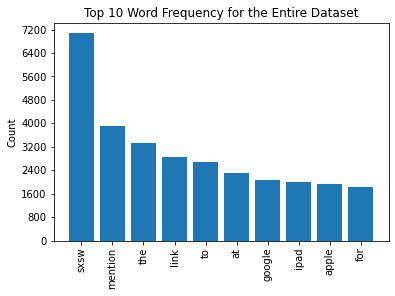

In [68]:
sample_freq_dist = FreqDist(df['Tokens'].explode())
visualize_top_10(sample_freq_dist, 
                 'Top 10 Word Frequency for the Entire Dataset')

Now I'll display the word frequencies for each of the targets.

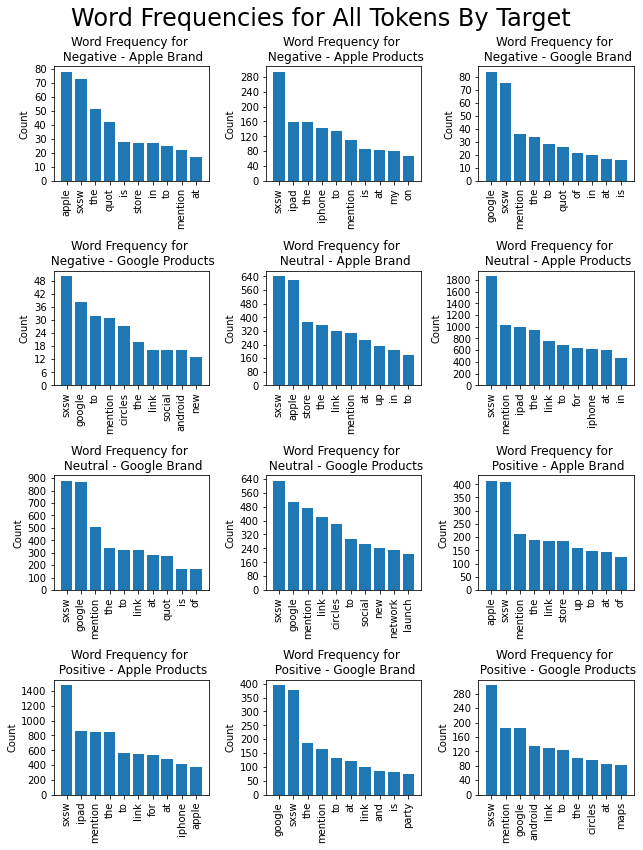

In [69]:
fig, axes = setup_twelve_subplots()
plots("Tokens", axes)
fig.suptitle("Word Frequencies for All Tokens By Target", fontsize=24);

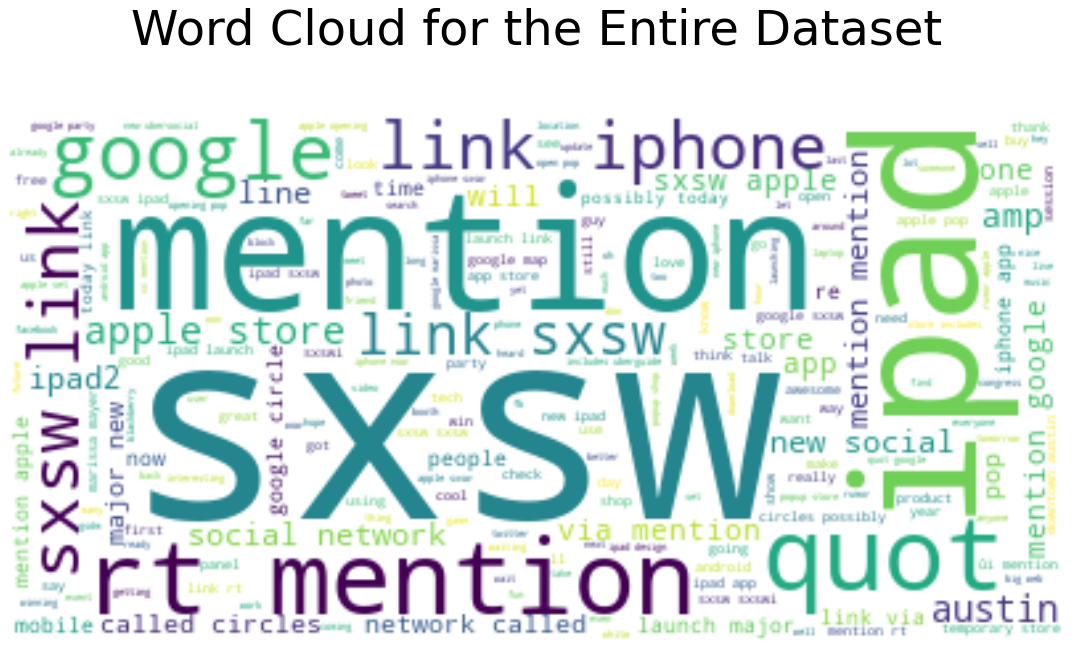

In [70]:
wc(df['Tokens'], title = "Word Cloud for the Entire Dataset")

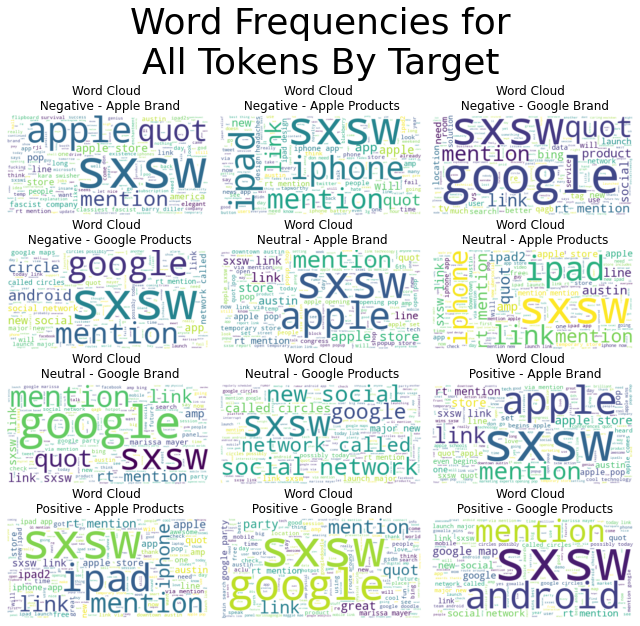

In [71]:
word_cloud_grid(title = "Word Frequencies for\nAll Tokens By Target")

### Splitting the data into Train and Test sets
I will use the 80/20 split for Train vs Test sets of data. I will split each target listed above by this same ratio.

In [72]:
#Creating the Test/Train split
x_train, x_test, y_train, y_test = train_test_split(
    df.iloc[:,0:-1],df.iloc[:,-1], train_size=.8, random_state = 42)

#I'm paranoid that the function will somehow pick few of one of the less common
#targets and then won't recognize it in the test. So I will test to see how
#close the ratio between train/test split is to the specified 0.8 train size
#for each target.

for targ in y_train.unique():
    train_size = y_train.value_counts()[targ]
    test_size = y_test.value_counts()[targ]
    train_perc = round(train_size/(train_size + test_size),3)
    print(targ, train_perc)

Positive - Apple Products 0.801
Neutral - Apple Products 0.792
Neutral - Google Products 0.775
Neutral - Google Brand 0.812
Neutral - Apple Brand 0.808
Negative - Apple Products 0.826
Positive - Apple Brand 0.817
Positive - Google Products 0.791
Positive - Google Brand 0.802
Negative - Google Products 0.833
Negative - Apple Brand 0.792
Negative - Google Brand 0.8


I'm impressed. This is nigh perfect. I'll trust this function more in the future.

### Remove NAs for testing

In [73]:
#df_No_NAs = df_raw['emotion_in_tweet_is_directed_at'].notna()
df_to_trim = df['Product'].notna()
df_test = df[df_to_trim]
df_nan = df[~df_to_trim]
df_test.info()

KeyError: 'Product'

In [ ]:
df_nan

# Setting up the train and test.

I'll make two sets of train/test data, one for the raw data, the other for scaled numerica data.

In [ ]:
#y = df['churn']
#X = df.drop(['phone number', 'churn'], axis=1)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
#y_scl = df_scl['churn']
#X_scl = df_scl.drop(['phone number', 'churn'], axis=1)

In [ ]:
#X_train_scl, X_test_scl, y_train_scl, y_test_scl = train_test_split(
#    X_scl, y_scl, random_state=0)

# Model 1: Name of First Model

Reason for choosing model.

Questions for Morgan:
1. What should my Train Test split percentages be?
Typically 9000 stick to 20/25 for test.

What are the words that arise out of the positive or negative tweets that arise often? What services do people write about positively and negatively?

Write about how to use this model for the benefit. An actionable recommendation.


2. My steps are:
    1. Define the 5800 tweets as either Apple, Google, or delete them.
    2. Split data into Apple & Google Tweets. This will involve a word search seeing what key words are included in the tweet (Products and company names)
    3. Put it all in lower case.
    3a. Remove HTML, URLs, clean up mentions by deleting all @ symbols.
    4. Tokenize everything / evaluate frequencies
    5. Build a baseline model with TfidfVectorizer and MultinomialNB
    5a. Account Vectorizor
    6. The final NLP lab lists the next five considerations. I'm honestly a little puzzled by them at first glance as I did this a few months ago.
    * Do we remove stop words or not?
    * What should be counted as a token? Do we stem or lemmatize our text data, or leave the words as is? Do we want to include non-"words" in our tokens?
    * Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
    * Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
    * What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?
    
Target is part of the model.
The projects will require us to have a target for 